In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


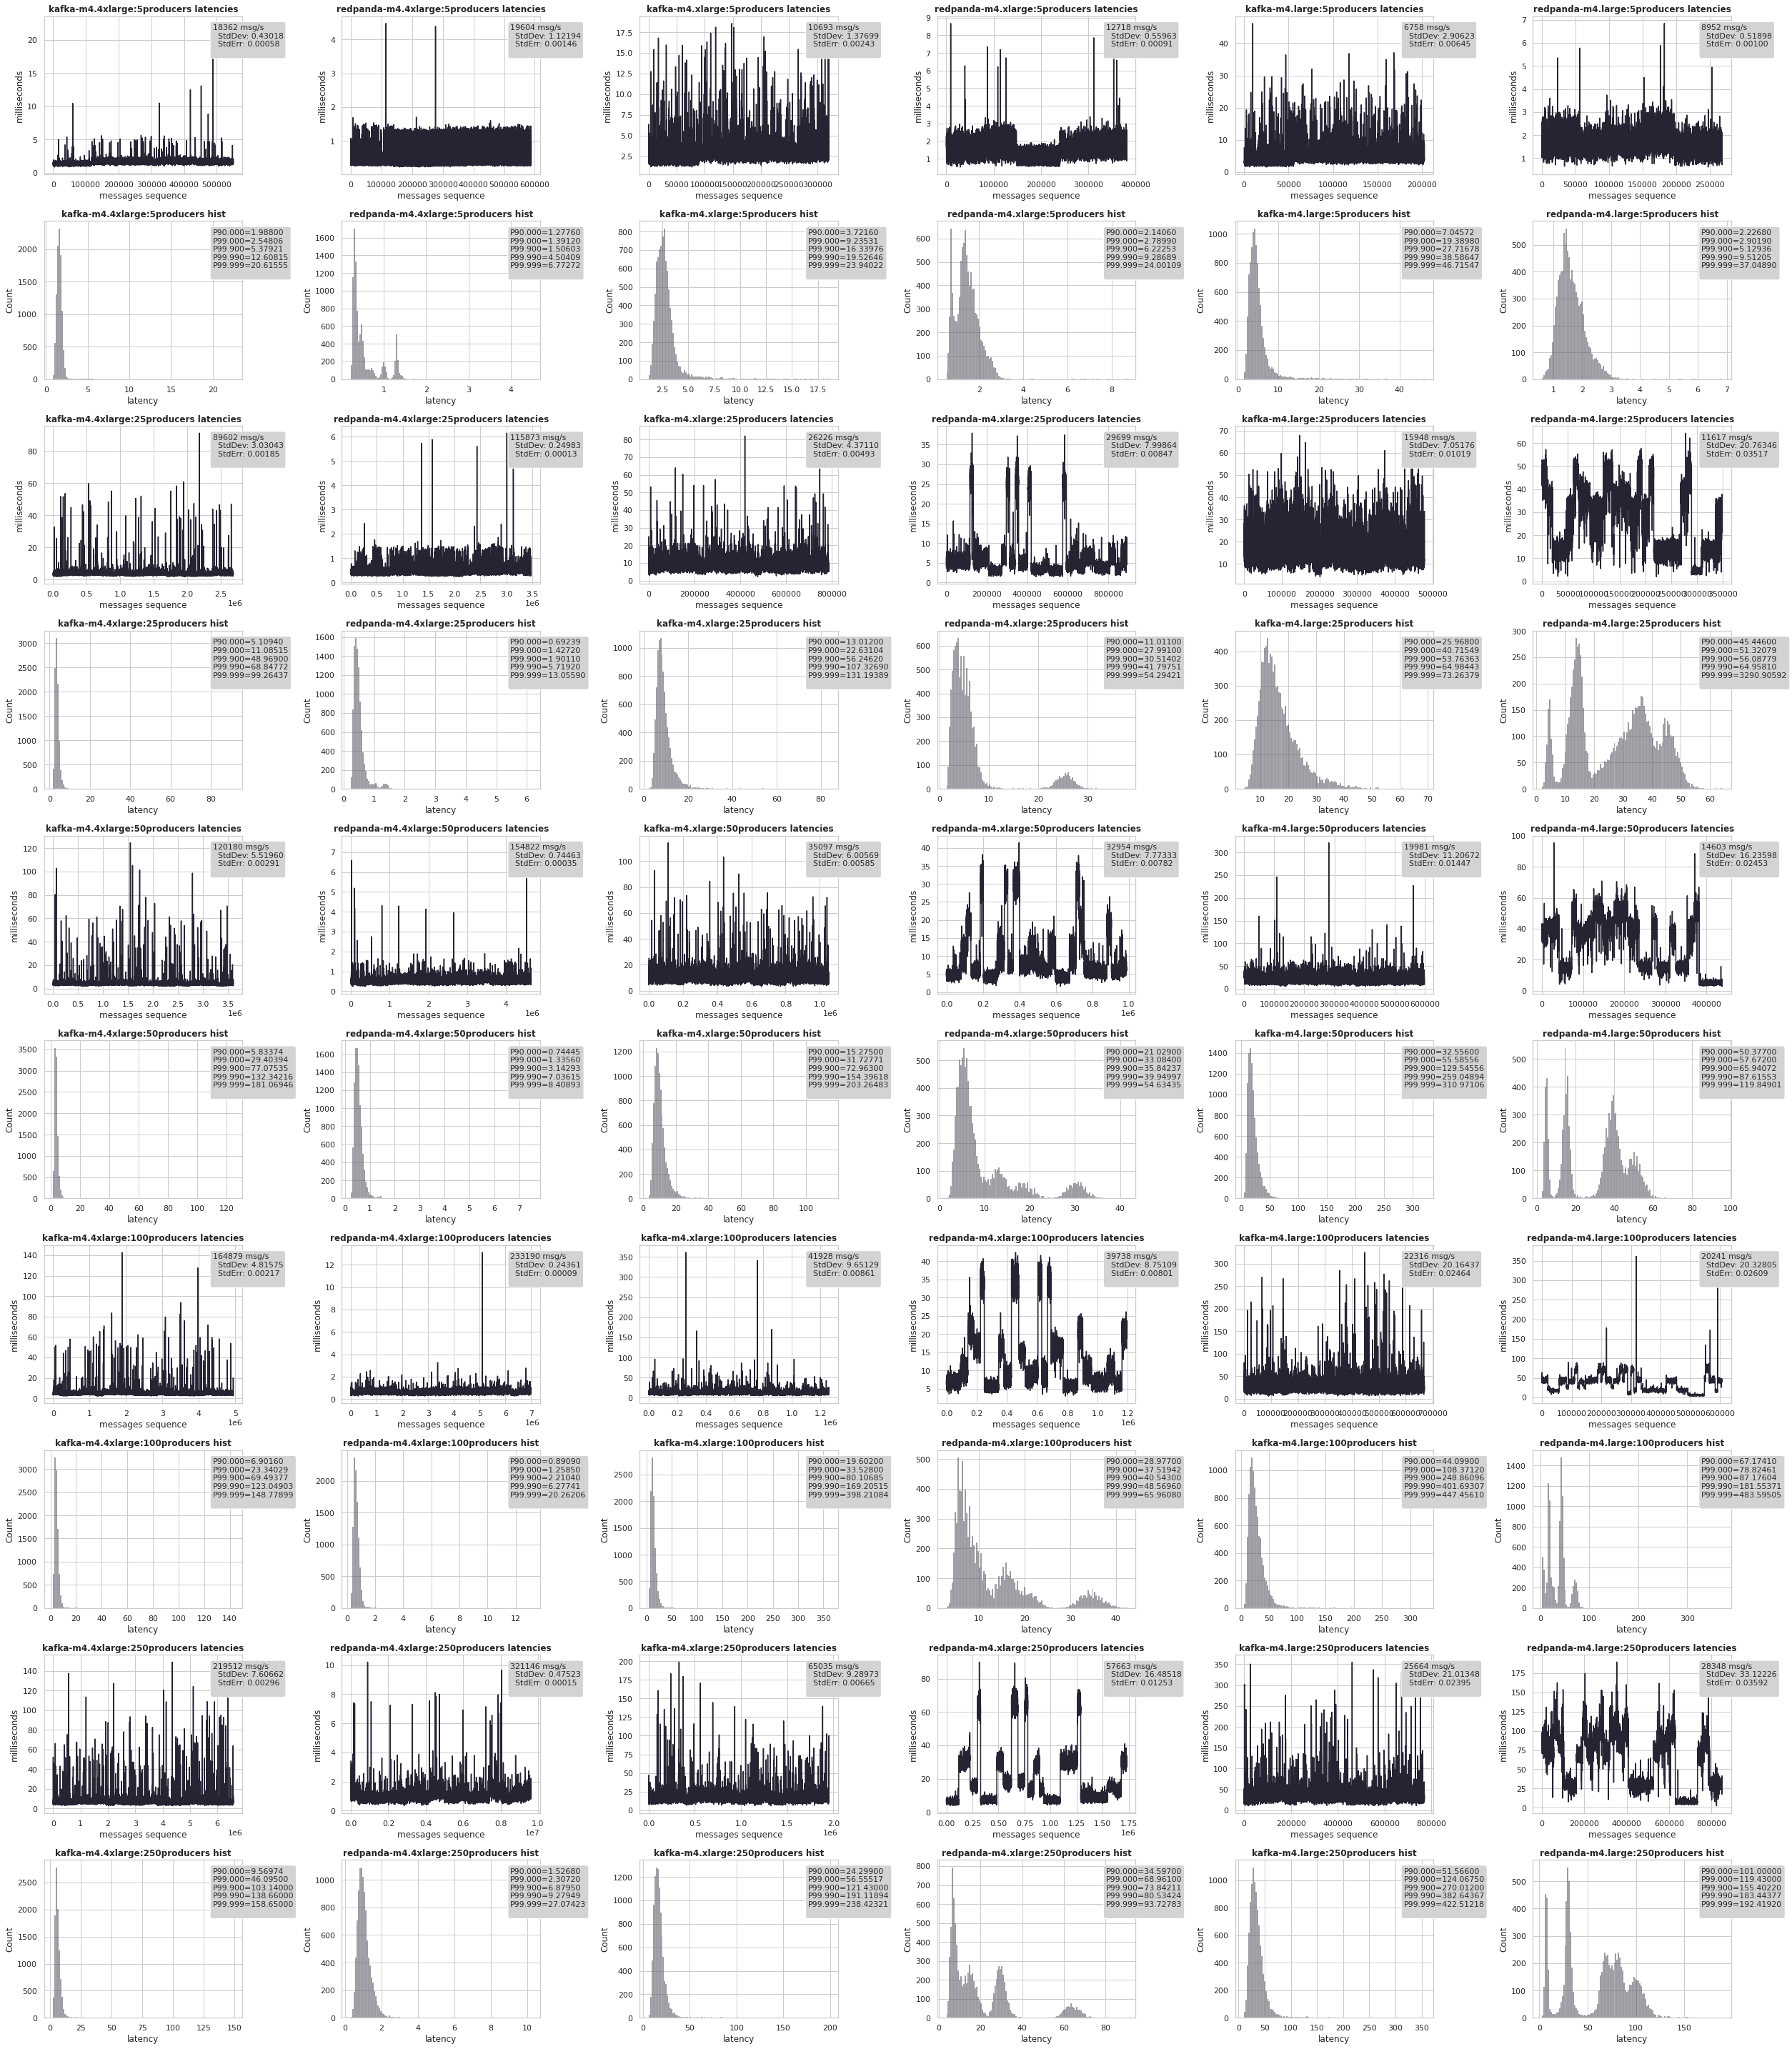

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


def draw_it(tests, envs):
  sn.set_theme(style="whitegrid", palette=sn.dark_palette("blue"))

  fig = plt.figure(figsize=[35, 8 * len(tests)])

  for i, test in enumerate(tests):
    for j, env in enumerate(envs):

      # print(f"###### {env}:{test} ######\n")
      df = pd.read_csv(f'/gdrive/My Drive/benchmarks/{env}/{test}/latencies.csv', names=["latency"])

      # * 10 because data is 10% sampling
      # / 300 because benchmark ran for 5 minutes (300 sec)
      thr = len(df)*10/300
      std = df.std()['latency']
      gtext = f'''{int(thr)} msg/s
  StdDev: {std:1.5f}
  StdErr: {df.sem()['latency']:1.5f}
  '''
      htext = ""
      for q in [0.9,0.99,0.999,0.9999,0.99999]:
        htext+=f"P{q*100:1.3f}={df.quantile(q)['latency']:03.5f}\n"


      # Subsample dataset (already sampled actually) by limiting it to 10k data points
      # so graphs and histograms will be plotted faster.
      df = df.sample(n=10000)
      
      ax1 = fig.add_subplot(len(tests) * 2, len(envs), i*len(envs)*2+j+1, xlabel="messages sequence", ylabel="milliseconds")
      ax1.set_title(f"{env}:{test} latencies", fontdict={'fontsize': 12, 'fontweight': "bold"})
      ax1.minorticks_on()
      sn.lineplot(data=df, ax=ax1, legend=False)
      #plt.yscale("log")
    
      props = dict(boxstyle='round', facecolor='lightgrey', alpha=1)

      ax1.text(0.85, 0.95, gtext, transform=ax1.transAxes, fontsize=11,
          verticalalignment='top', bbox=props)

      ax2 = fig.add_subplot(len(tests) * 2, len(envs), i*len(envs)*2+j+1+len(envs), xlabel="latency")
      ax2.set_title(f"{env}:{test} hist", fontdict={'fontsize': 12, 'fontweight': "bold"})
      ax2.minorticks_on()
      sn.histplot(data=df, bins=128, ax=ax2, legend=False)
      #plt.xscale("log")

      ax2.text(0.85, 0.95, htext, transform=ax2.transAxes, fontsize=11,
          verticalalignment='top', bbox=props)

  fig.tight_layout()


envs = ["kafka-m4.4xlarge","redpanda-m4.4xlarge","kafka-m4.xlarge","redpanda-m4.xlarge","kafka-m4.large","redpanda-m4.large"]
tests = ["5producers","25producers","50producers","100producers","250producers"]

draw_it(tests, envs)

# Fsync issue
There's a difference in how Kafka and Redpanda report acknowledge to the producer. Redpanda acknowledges the message once it is fsynced to disk. So even if broker's power is plugged off at this point you have a guarantee that message is flushed on the disk. In Kafka acknowledge does not wait for fsync.

We saw bad performance and "ugly" latency graphs and histograms for rendanda in low CPU scenario (2 and 4 cores - m4.large, m4.xlarge). The theory is that this is due to EBS fsync queue contention (redpanda acks are waiting for this, and kafka does not).

To validate this we introduced two more setups:
1. kafka on m4.xlarge with `log.flush.interval.messages=1`
2. both kafka and redpanda on m5dn.large with local NVME SSD storage

The idea is to see how kafka with fsync for every batch will perform and if the redpanda performance will improve significantly on low CPU machine with high IOPS and low fsync latency.

# Kafka with fsync enabled vs Redpanda
This run lacks `5producer` case because we accidentally shut down Kafka cluster before this benchmark has finished (it was running last) 🤦

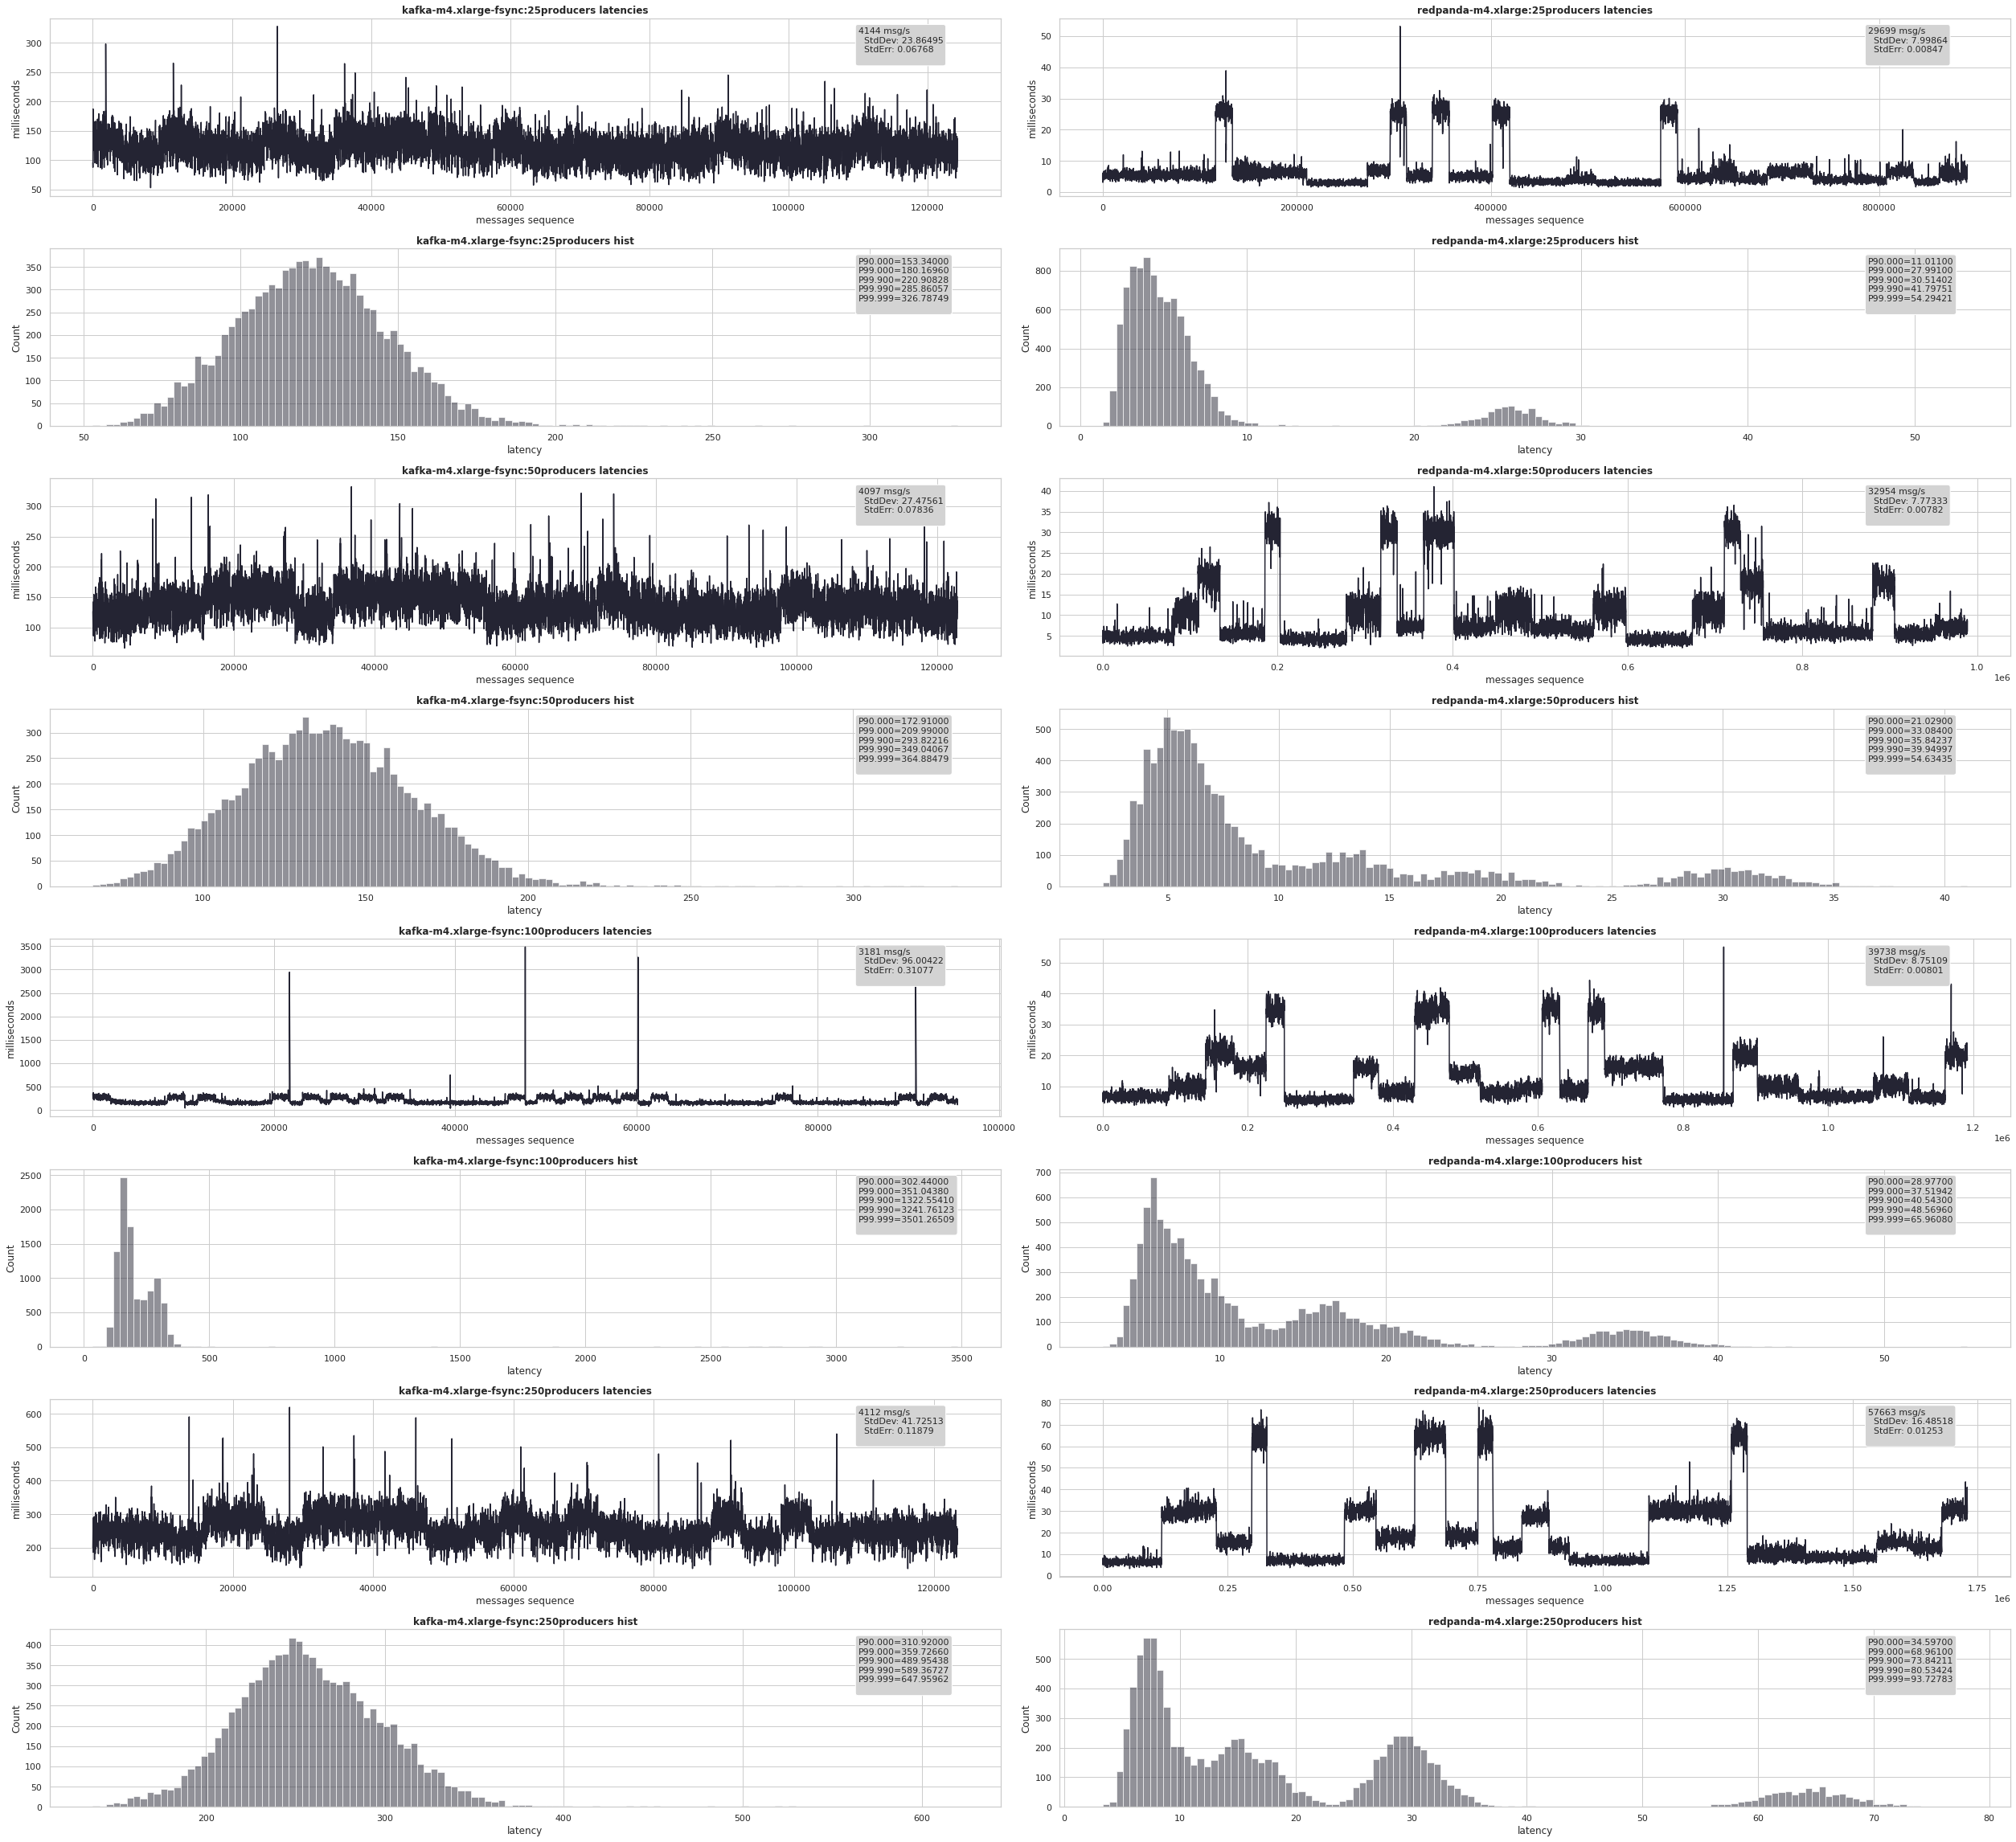

In [4]:
envs = ["kafka-m4.xlarge-fsync","redpanda-m4.xlarge"]
tests = ["25producers","50producers","100producers","250producers"]

draw_it(tests, envs)

# NVME SSD

Test on 2 CPU instance with local NVME SSD drive (m5dn.large)

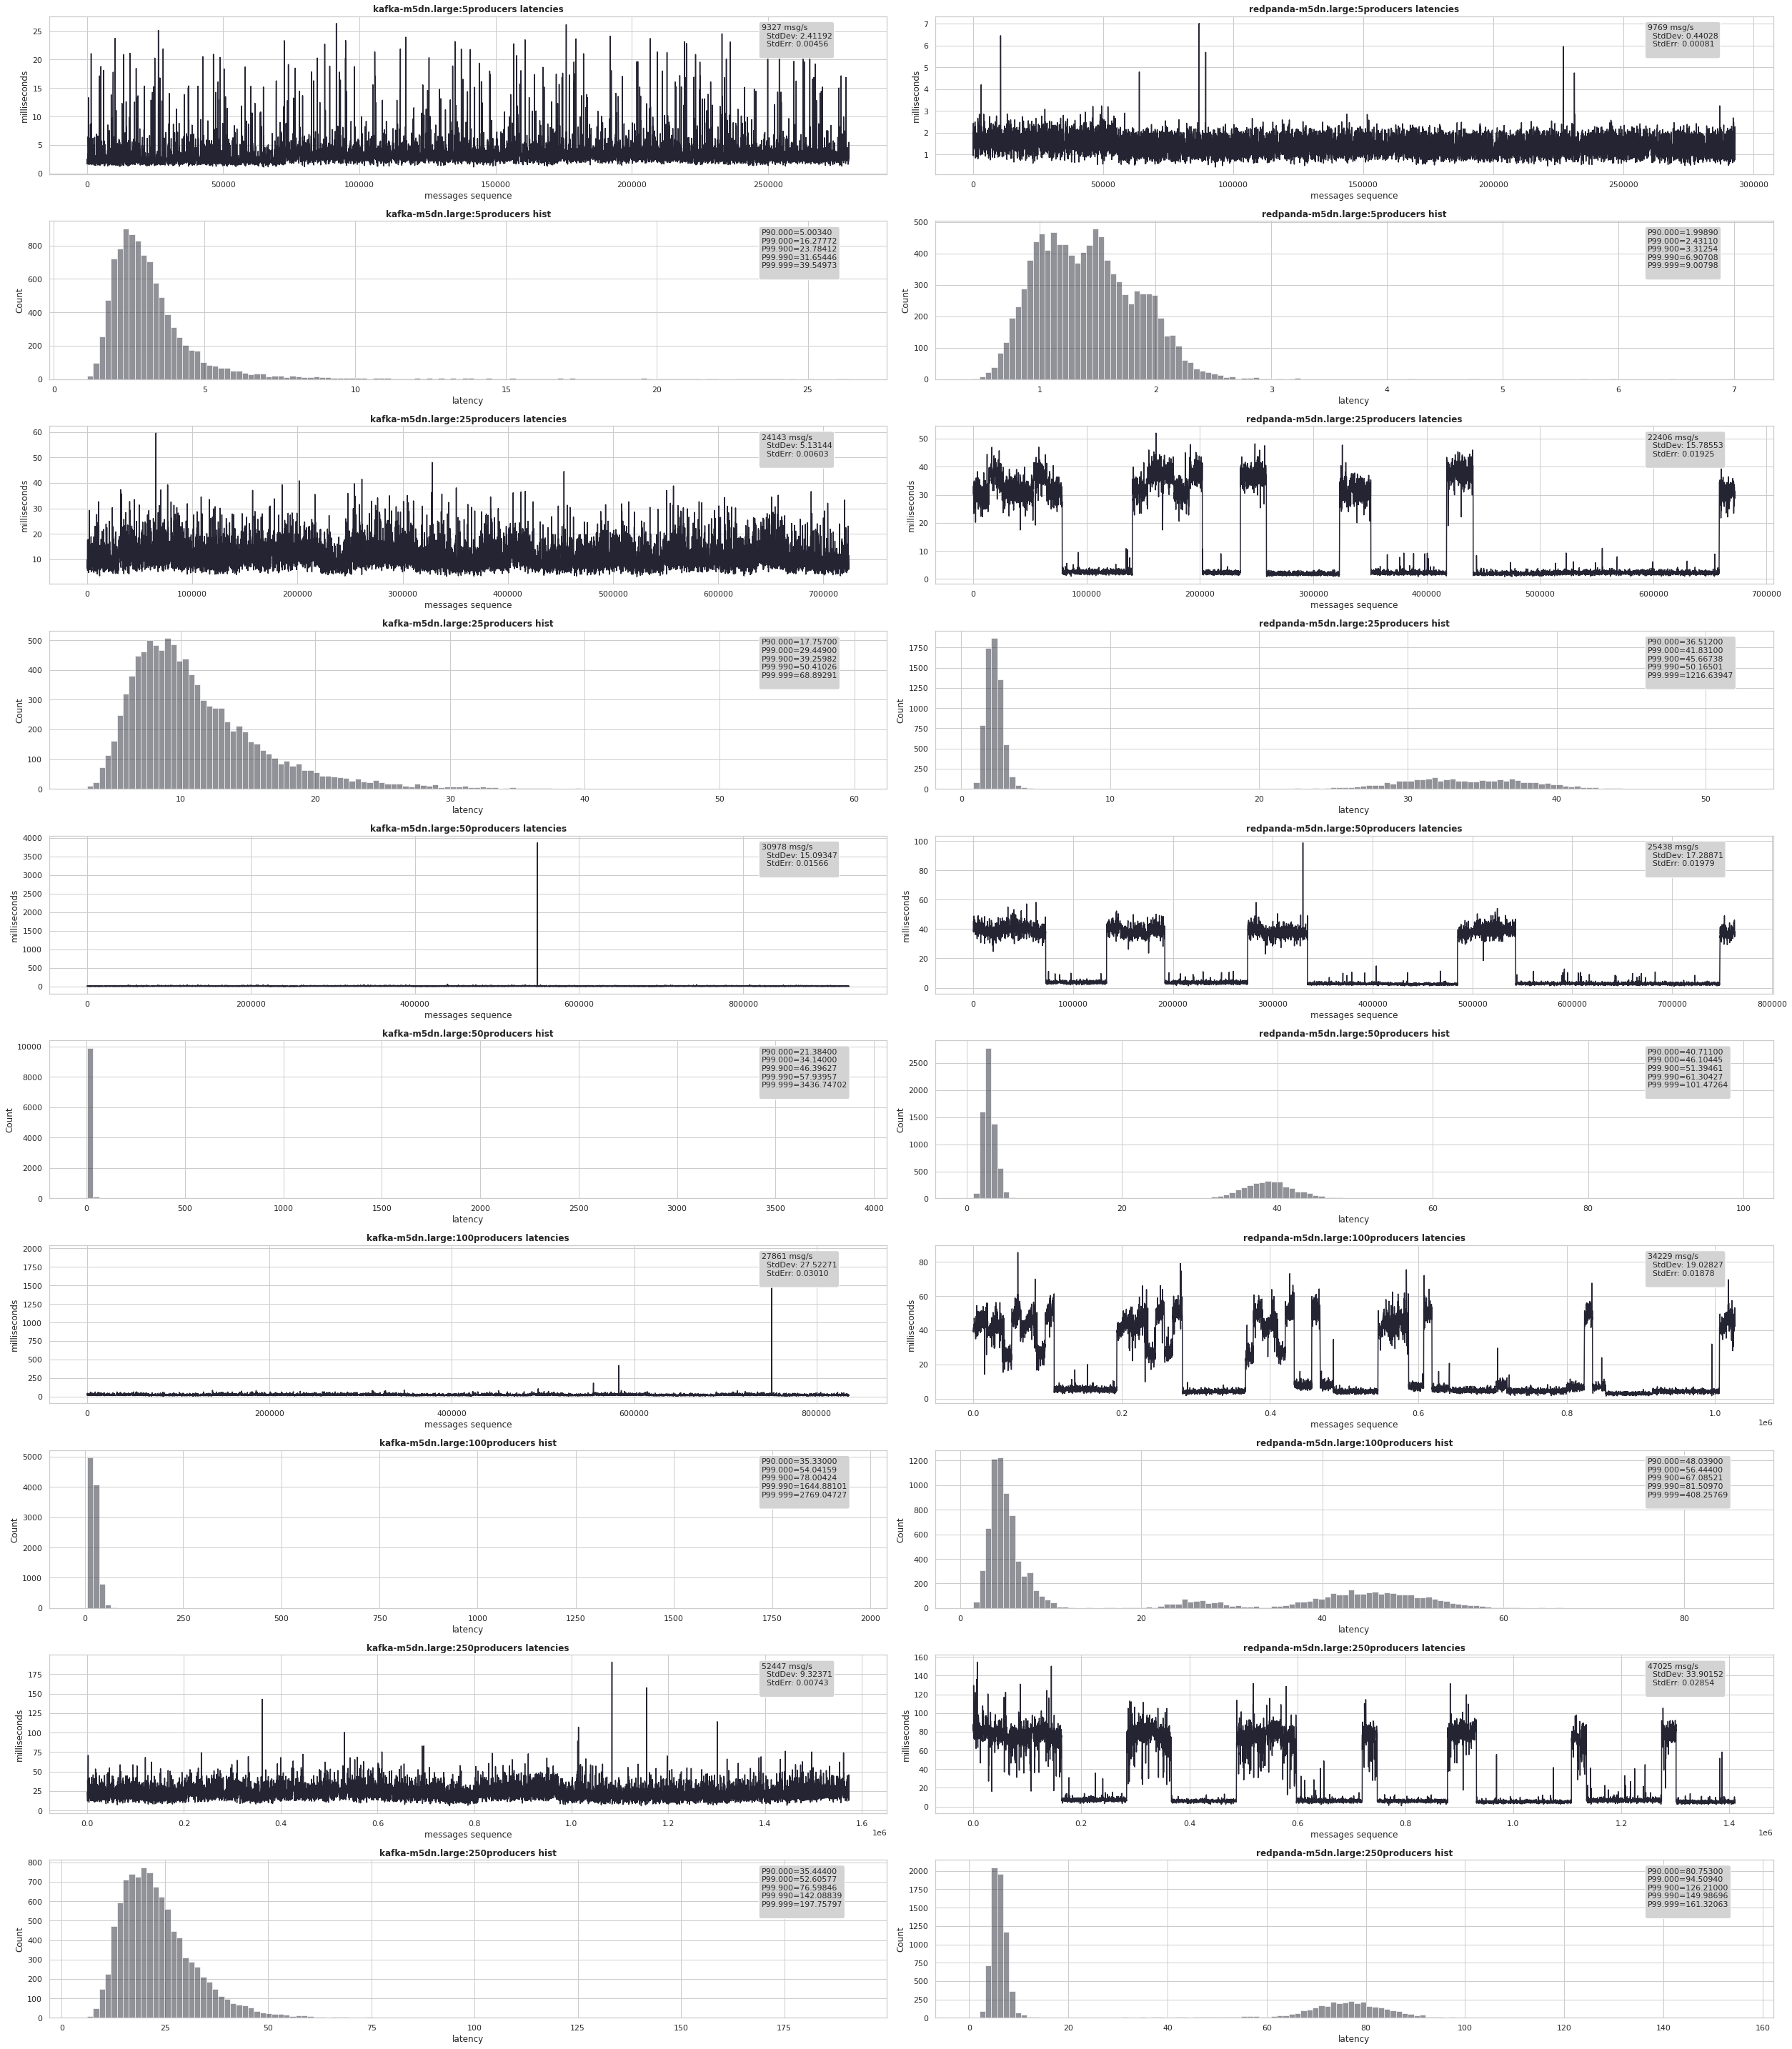

In [6]:
envs = ["kafka-m5dn.large","redpanda-m5dn.large"]
tests = ["5producers","25producers","50producers","100producers","250producers"]

draw_it(tests, envs)

# Redpanda on NVMe vs Redpanda on EBS

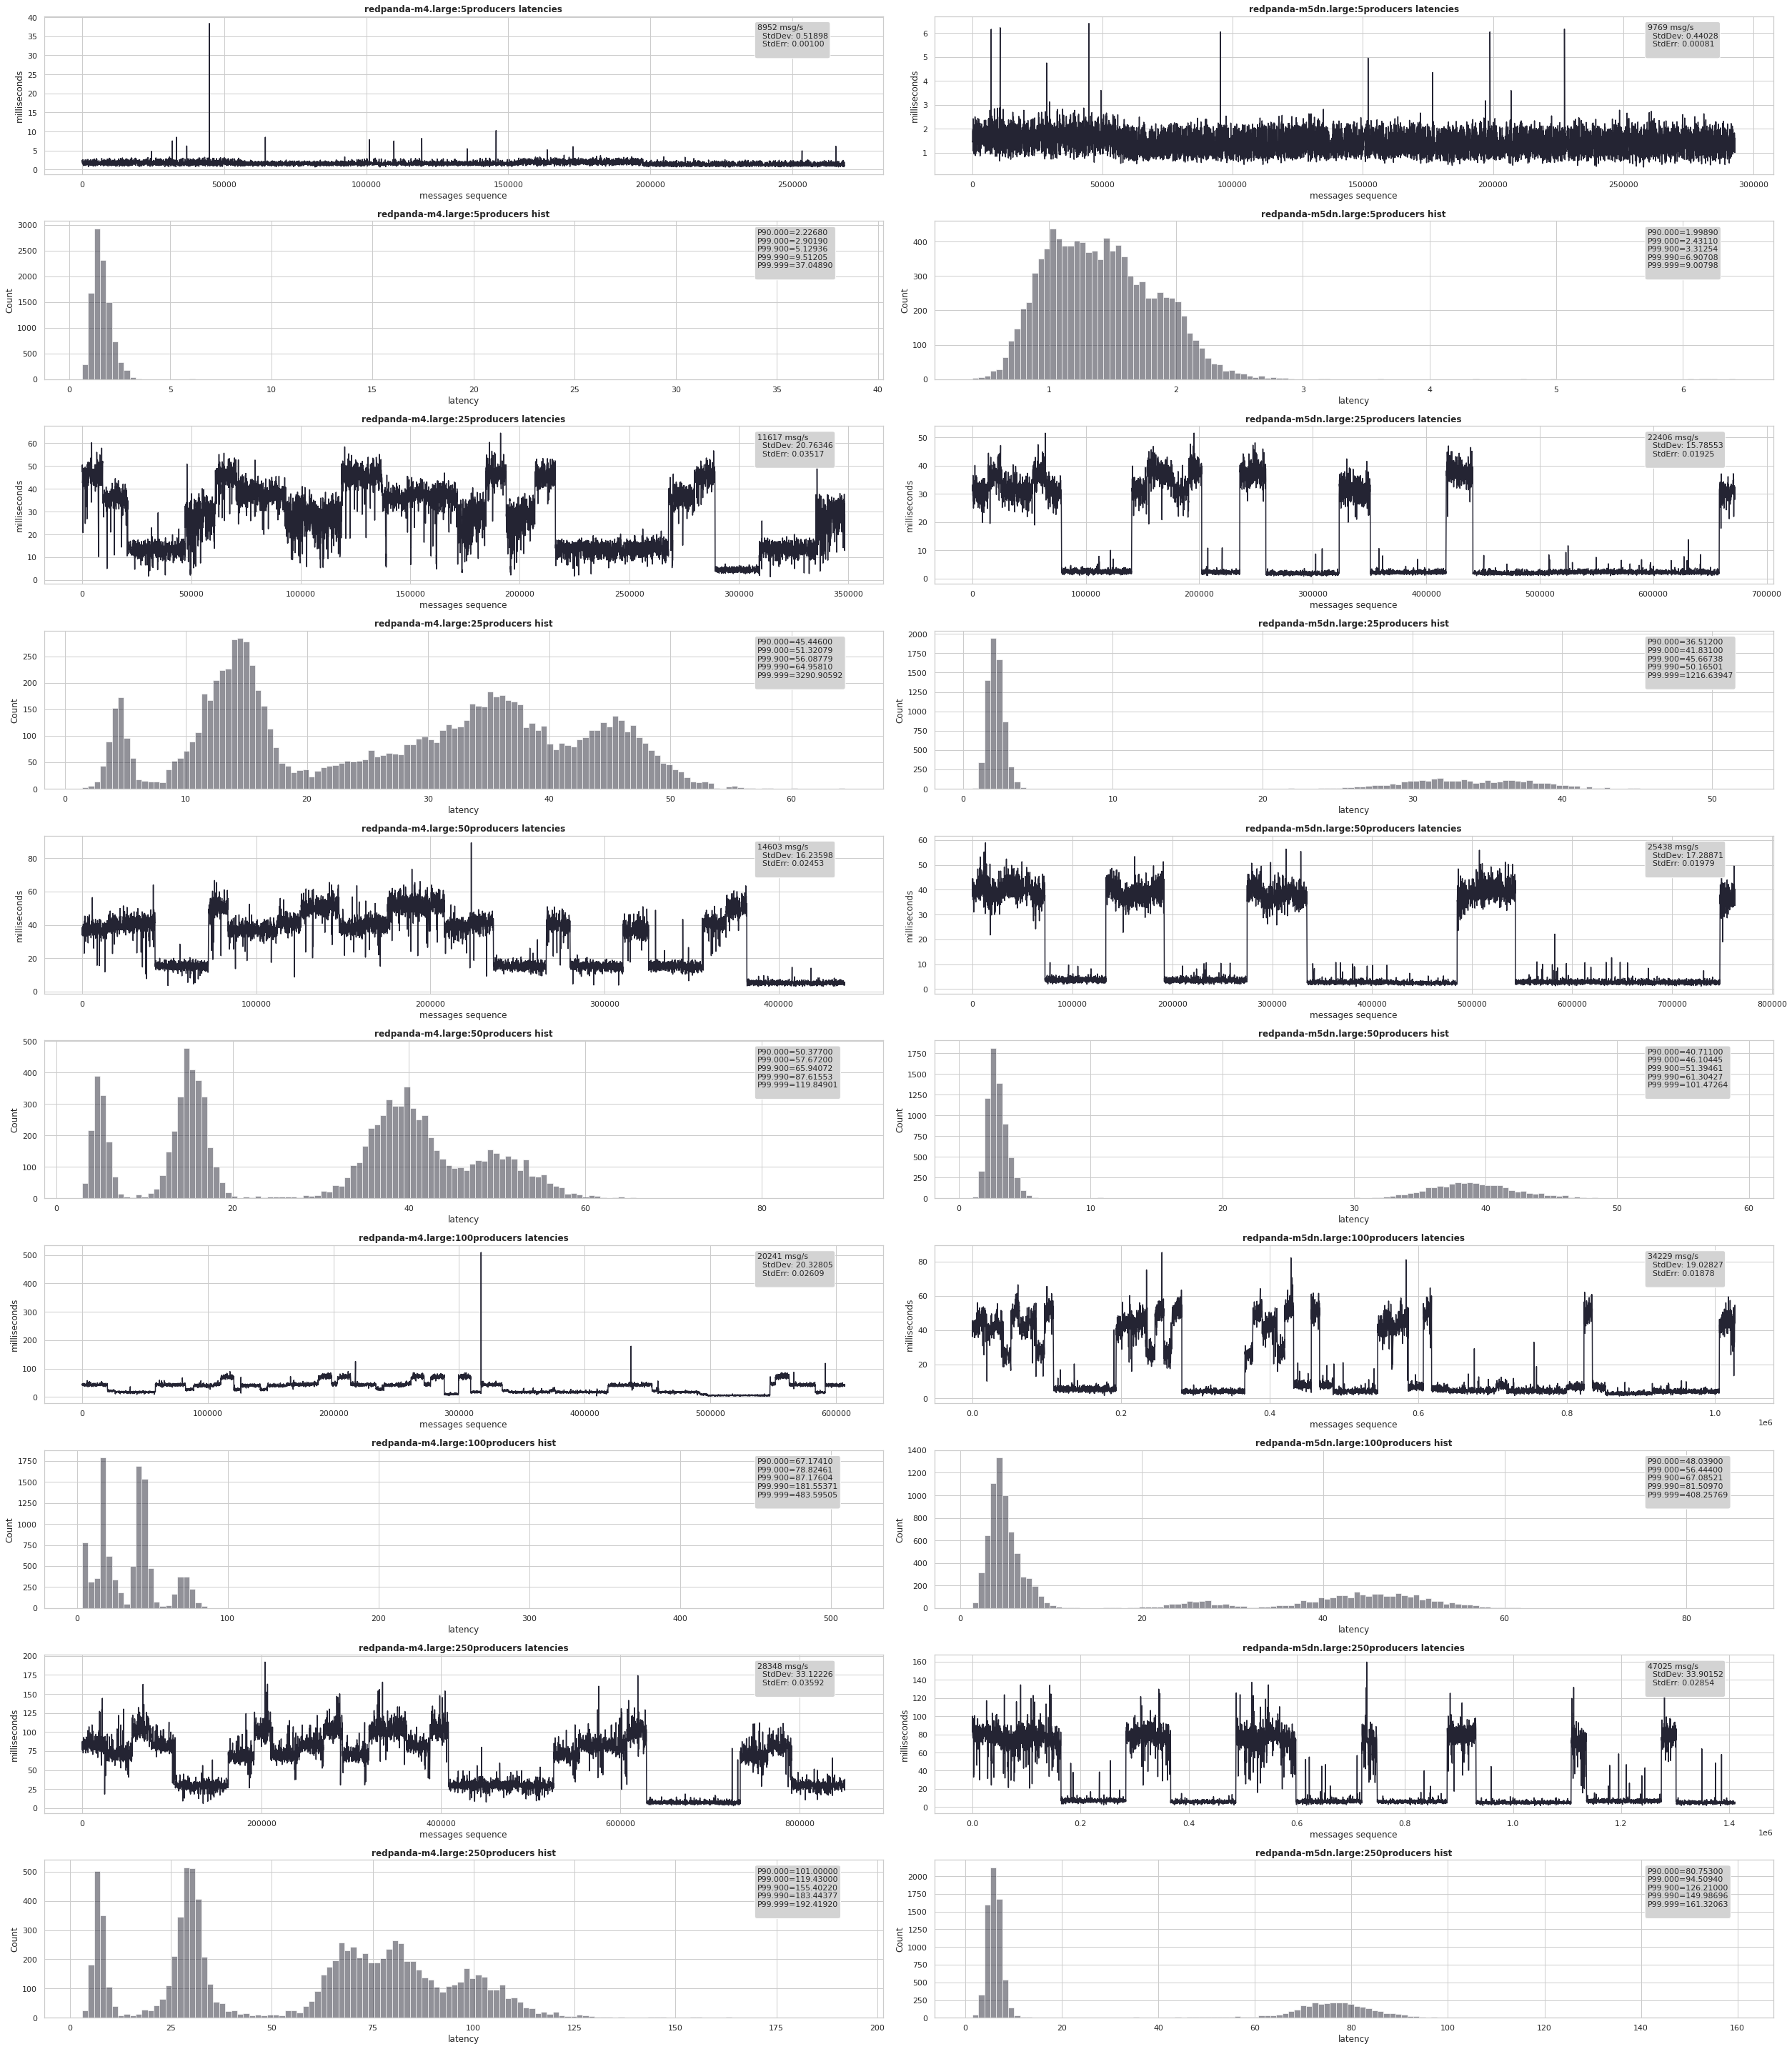

In [7]:
envs = ["redpanda-m4.large","redpanda-m5dn.large"]
tests = ["5producers","25producers","50producers","100producers","250producers"]

draw_it(tests, envs)